In [37]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import grad
import torch.nn.functional as F

In [38]:
df = pd.read_csv('iris.data', index_col = None, header = None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.tail()

,x1,x2,x3,x4,y
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [39]:
X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [40]:
class Adaline():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype = torch.float, requires_grad = True)
        self.bias = torch.zeros(1, dtype = torch.float, requires_grad = True)
        
    def forward(self, X):
        net_input = torch.add(torch.mm(X, self.weights), self.bias)
        activations = net_input
        return activations.view(-1)

In [41]:
def loss_func(yhat,y):
    return torch.mean((yhat - y)**2)

def train(model, X, y, epochs, minibatch_size, seed = 123, learning_rate = 0.01):
    cost = []
    
    torch.manual_seed(seed)    
    for j in range(epochs):
        
        shuffle_idx = torch.randperm(y.size(0), dtype = torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        for i in minibatches:
            # Forward Propagation
            yhat = model.forward(X[i])
            loss = loss_func(yhat,y[i])
            
            # Backward Propagation using autograd
            neg_grad_weight = grad(loss, model.weights, retain_graph=True)[0] * (-1)
            neg_grad_bias = grad(loss, model.bias)[0] * (-1)
            
            model.weights = model.weights + learning_rate*(neg_grad_weight)
            model.bias = model.bias + learning_rate*(neg_grad_bias)
            
        #### Logging ####
        with torch.no_grad():
            # context manager to
            # avoid building graph during "inference"
            # to save memory
            yhat = model.forward(X)
            curr_loss = loss_func(yhat, y)
            print('Epoch: %03d' % (j+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)
    
    return cost

In [42]:
model = Adaline(num_features = X_train.size(1))
cost = train(model, X_train, y_train, epochs = 100, minibatch_size = 10, seed =123, learning_rate = 0.01)

Epoch: 001 | MSE: 0.37450
Epoch: 002 | MSE: 0.29561
Epoch: 003 | MSE: 0.24045
Epoch: 004 | MSE: 0.20103
Epoch: 005 | MSE: 0.17261
Epoch: 006 | MSE: 0.15227
Epoch: 007 | MSE: 0.13730
Epoch: 008 | MSE: 0.12608
Epoch: 009 | MSE: 0.11788
Epoch: 010 | MSE: 0.11157
Epoch: 011 | MSE: 0.10692
Epoch: 012 | MSE: 0.10338
Epoch: 013 | MSE: 0.10056
Epoch: 014 | MSE: 0.09832
Epoch: 015 | MSE: 0.09658
Epoch: 016 | MSE: 0.09522
Epoch: 017 | MSE: 0.09413
Epoch: 018 | MSE: 0.09325
Epoch: 019 | MSE: 0.09251
Epoch: 020 | MSE: 0.09191
Epoch: 021 | MSE: 0.09143
Epoch: 022 | MSE: 0.09102
Epoch: 023 | MSE: 0.09066
Epoch: 024 | MSE: 0.09037
Epoch: 025 | MSE: 0.09014
Epoch: 026 | MSE: 0.08994
Epoch: 027 | MSE: 0.08977
Epoch: 028 | MSE: 0.08963
Epoch: 029 | MSE: 0.08951
Epoch: 030 | MSE: 0.08941
Epoch: 031 | MSE: 0.08931
Epoch: 032 | MSE: 0.08924
Epoch: 033 | MSE: 0.08918
Epoch: 034 | MSE: 0.08913
Epoch: 035 | MSE: 0.08908
Epoch: 036 | MSE: 0.08904
Epoch: 037 | MSE: 0.08901
Epoch: 038 | MSE: 0.08898
Epoch: 039 |

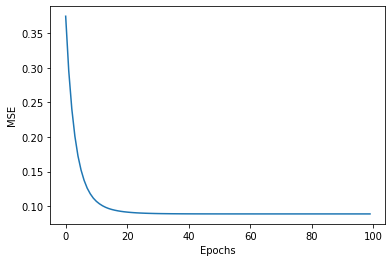

In [43]:
plt.plot(range(len(cost)),cost)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [44]:
ones = torch.ones(y_train.size(0))
zeros = torch.zeros(y_train.size(0))
train_pred = model.forward(X_train)
train_acc = torch.mean((torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float())

ones = torch.ones(y_test.size(0))
zeros = torch.zeros(y_test.size(0))
test_pred = model.forward(X_test)
test_acc = torch.mean((torch.where(test_pred > 0.5, ones, zeros).int() == y_test).float())

print('Training accuracy %0.2f' % (train_acc*100))
print('Test accuracy %0.2f' % (test_acc*100))

Training accuracy 91.25
Test accuracy 95.00
